In [1]:
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use("Agg") #Needed to save figures
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py:6: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/hminle/miniconda2/e

In [2]:
from datetime import datetime
from bisect import bisect_right, bisect_left
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

## Load and Explore Data

In [4]:
fraud_data_df = pd.read_csv('./data/Fraud_Data.csv')
ip_address_country_df = pd.read_csv('./data/IpAddress_to_Country.csv')
country_continent = pd.read_csv('./data/countryContinent.csv', encoding='latin1')

In [5]:
fraud_data_df.head()

user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   

       device_id source browser sex  age    ip_address  class  
0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0

In [6]:
ip_address_country_df.head()

lower_bound_ip_address  upper_bound_ip_address    country
0              16777216.0                16777471  Australia
1              16777472.0                16777727      China
2              16777728.0                16778239      China
3              16778240.0                16779263  Australia
4              16779264.0                16781311      China

In [7]:
country_continent.head()

country code_2 code_3  country_code     iso_3166_2 continent  \
0     Afghanistan     AF    AFG             4  ISO 3166-2:AF      Asia   
1   Åland Islands     AX    ALA           248  ISO 3166-2:AX    Europe   
2         Albania     AL    ALB             8  ISO 3166-2:AL    Europe   
3         Algeria     DZ    DZA            12  ISO 3166-2:DZ    Africa   
4  American Samoa     AS    ASM            16  ISO 3166-2:AS   Oceania   

        sub_region  region_code  sub_region_code  
0    Southern Asia        142.0             34.0  
1  Northern Europe        150.0            154.0  
2  Southern Europe        150.0             39.0  
3  Northern Africa          2.0             15.0  
4        Polynesia          9.0             61.0

In [8]:
country_continent = country_continent[['country', 'continent']]

In [9]:
# sns.countplot(x='browser', data=fraud_data_df)

In [10]:
# sns.countplot(x='sex', data=fraud_data_df)

In [11]:
# sns.countplot(x='class', data=fraud_data_df)

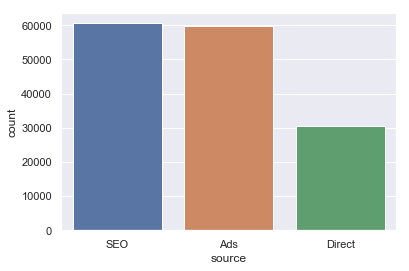

In [12]:
sns.countplot(x='source', data=fraud_data_df)

In [13]:
# fraud_data_df.signup_time.tolist()[0]

In [14]:
# datetime.strptime('2015-02-10 13:01:40', '%Y-%m-%d %H:%M:%S').month

## Enrichment

If you encode time as numeric, then you are imposing certain restrictions on the model. For a linear regression model, the effect of time is now monotonic, either the target will increase or decrease with time. For decision trees, time values close to each other will be grouped together.

Encoding time as categorical gives the model more flexibility, but in some cases, the model may not have enough data to learn well. One technique that may be useful is to group time values together into some number of sets, and use the set as a categorical attribute.

Some example groupings:

- For month, group into quarters or seasons, depending upon the use case. Eg: Jan-Mar, Apr-Jun, etc.
- For hour-of-day, group into time-of-day buckets: morning, evening, etc,
- For day-of-week, group into weekday, weekend.

Each of the above can also be used directly as a categorical attribute as well, given enough data. Further, groupings can also be discovered by data analysis, to complement a domain knowledge based approach.

In [15]:
def get_quarter(time_str):
    time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
    month = time.month
    if month in [1, 2, 3]:
        return "Q1"
    elif month in [4, 5, 6]:
        return "Q2"
    elif month in [7, 8, 9]:
        return "Q3"
    else:
        return "Q4"

In [16]:
def get_day_of_week(time_str):
    time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
    # Monday: 0, Sunday: 6
    return time.weekday()

In [17]:
def isWeekend(time_str):
    time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S')
    weekday = time.weekday()
    if weekday in [5, 6]:
        return 1
    return 0

In [18]:
sorted_lower_bound = sorted(ip_address_country_df.lower_bound_ip_address.tolist())
original_upper_bound = ip_address_country_df.upper_bound_ip_address.tolist()
country_list = ip_address_country_df.country.tolist()

def get_country_name(ip_address, sorted_lower_bound, original_upper_bound, country_list, ip_address_country_df):
    index = bisect_left(sorted_lower_bound, ip_address)
    lower_bound = sorted_lower_bound[index-1]
    matched_list = ip_address_country_df.index[ip_address_country_df['lower_bound_ip_address'] == lower_bound].tolist()
    df_index = matched_list[0]
    if ip_address < original_upper_bound[df_index]:
        return country_list[df_index]
    return np.nan

In [19]:
fraud_data_df['country'] = fraud_data_df.apply(lambda row: get_country_name(row['ip_address'], 
                                                                            sorted_lower_bound, 
                                                                            original_upper_bound,
                                                                            country_list,
                                                                            ip_address_country_df), axis=1)

In [20]:
def fix_country(old_country):
    if old_country == 'United States of America':
        return 'United States'
    if old_country == 'United Kingdom of Great Britain and Northern Ireland':
        return 'United Kingdom'
    if old_country == 'Korea (Republic of)':
        return 'Korea Republic of'
    if old_country == 'Iran (Islamic Republic of)':
        return 'Iran (ISLAMIC Republic Of)'
    return old_country.copy()

In [21]:
rep_dict = {'United States of America': 'United States', 
            'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
           'Korea (Republic of)': 'Korea Republic of',
           'Iran (Islamic Republic of)': 'Iran (ISLAMIC Republic Of)'}

In [22]:
country_continent.head()

country continent
0     Afghanistan      Asia
1   Åland Islands    Europe
2         Albania    Europe
3         Algeria    Africa
4  American Samoa   Oceania

In [23]:
country_continent['country'] = country_continent['country'].replace(rep_dict)

In [24]:
merged_fraud_df = fraud_data_df.merge(country_continent, on='country', how='left')

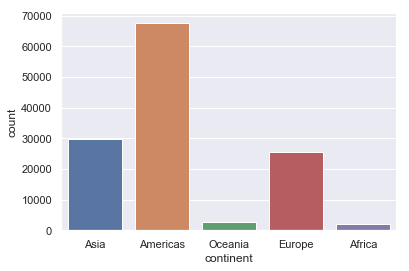

In [25]:
sns.countplot(x='continent', data=merged_fraud_df)

In [26]:
merged_fraud_df['quarter_signup'] = fraud_data_df.apply(lambda row: get_quarter(row['signup_time']), axis=1)
merged_fraud_df['quarter_purchase'] = fraud_data_df.apply(lambda row: get_quarter(row['purchase_time']), axis=1)

In [27]:
def get_life_stage(age):
    if age <= 18:
        return 'teen'
    if age > 18 and age <= 30:
        return 'early_adult'
    if age > 30 and age <= 45:
        return 'mature_adult'
    if age > 45 and age < 60:
        return 'late_adult'
    if age > 60:
        return 'old_age'
    return np.nan

In [28]:
merged_fraud_df['life_stage'] = merged_fraud_df.apply(lambda row: get_life_stage(row['age']), axis=1)

In [29]:
# sns.countplot(x='age', data=merged_fraud_df)

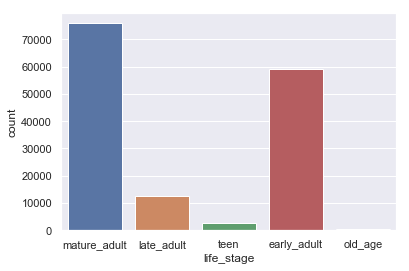

In [30]:
sns.countplot(x='life_stage', data=merged_fraud_df)

In [31]:
merged_fraud_df['purchase_isWeekend'] = merged_fraud_df.apply(lambda row: isWeekend(row['purchase_time']), axis=1)

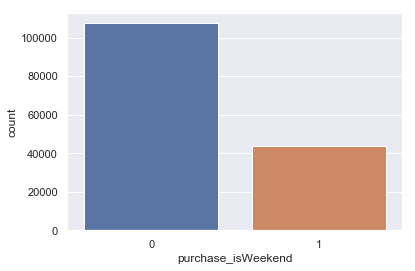

In [32]:
sns.countplot(x='purchase_isWeekend', data=merged_fraud_df)

In [33]:
merged_fraud_df['signup_isWeekend'] = merged_fraud_df.apply(lambda row: isWeekend(row['signup_time']), axis=1)

In [34]:
# sns.countplot(x='signup_isWeekend', data=merged_fraud_df)

### One-hot encode

In [35]:
merged_fraud_df_selected = merged_fraud_df[['purchase_value',
                                   'source',
                                   'browser',
                                   'sex',
                                   'continent',
                                   'quarter_signup',
                                   'quarter_purchase',
                                   'life_stage',
                                   'purchase_isWeekend',
                                   'signup_isWeekend',
                                   'class']]

In [36]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
imp = SimpleImputer(strategy="most_frequent")
le = LabelEncoder()

In [37]:
merged_fraud_df_selected.isna().any()

purchase_value        False
source                False
browser               False
sex                   False
continent              True
quarter_signup        False
quarter_purchase      False
life_stage             True
purchase_isWeekend    False
signup_isWeekend      False
class                 False
dtype: bool

In [38]:
merged_fraud_df_selected['continent'] = imp.fit_transform(merged_fraud_df_selected[['continent']])
merged_fraud_df_selected['life_stage'] = imp.fit_transform(merged_fraud_df_selected[['life_stage']])

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [39]:
merged_fraud_df_selected.isna().any()

purchase_value        False
source                False
browser               False
sex                   False
continent             False
quarter_signup        False
quarter_purchase      False
life_stage            False
purchase_isWeekend    False
signup_isWeekend      False
class                 False
dtype: bool

In [40]:
X = merged_fraud_df_selected[['purchase_value',
                                   'source',
                                   'browser',
                                   'sex',
                                   'continent',
                                   'quarter_signup',
                                   'quarter_purchase',
                                   'life_stage',
                                   'purchase_isWeekend',
                                   'signup_isWeekend']].values
y = merged_fraud_df_selected[['class']].values

In [41]:
X = ohe.fit_transform(X)

In [42]:
del fraud_data_df
del ip_address_country_df
del country_continent
del merged_fraud_df
# del merged_fraud_df_selected

## Train test split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random.seed(2016))

## Training

In [44]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
# model = xgb.XGBClassifier()

In [45]:
# model.fit(X_train, y_train)

In [46]:
from sklearn.linear_model import LogisticRegression

In [47]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/hminle/miniconda2/envs/pydata/lib/python3.5/site-packages/sklearn/utils/validation.py:752: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [48]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.91


## Report

In [49]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     27399
           1       0.56      0.00      0.01      2824

   micro avg       0.91      0.91      0.91     30223
   macro avg       0.73      0.50      0.48     30223
weighted avg       0.87      0.91      0.86     30223



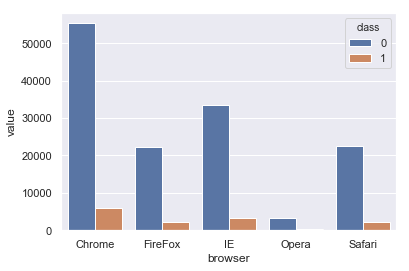

In [55]:
ct = pd.crosstab(merged_fraud_df_selected['browser'],merged_fraud_df_selected['class'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.browser, y=stacked.value, hue=stacked['class'])

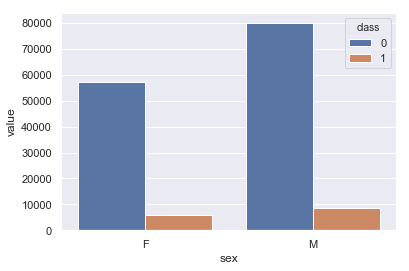

In [57]:
ct = pd.crosstab(merged_fraud_df_selected['sex'],merged_fraud_df_selected['class'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.sex, y=stacked.value, hue=stacked['class'])

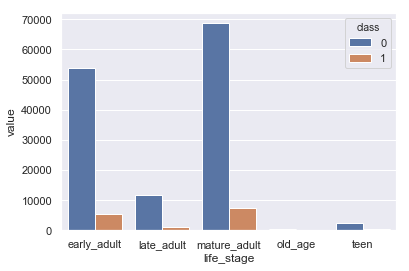

In [58]:
ct = pd.crosstab(merged_fraud_df_selected['life_stage'],merged_fraud_df_selected['class'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.life_stage, y=stacked.value, hue=stacked['class'])

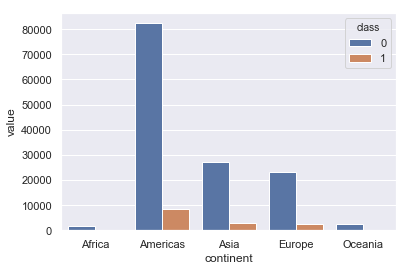

In [59]:
ct = pd.crosstab(merged_fraud_df_selected['continent'],merged_fraud_df_selected['class'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.continent, y=stacked.value, hue=stacked['class'])

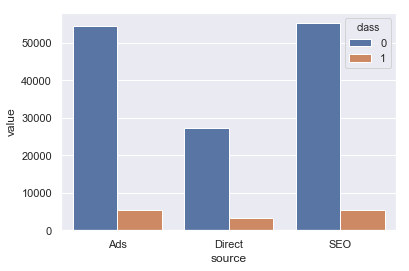

In [61]:
ct = pd.crosstab(merged_fraud_df_selected['source'],merged_fraud_df_selected['class'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.source, y=stacked.value, hue=stacked['class'])

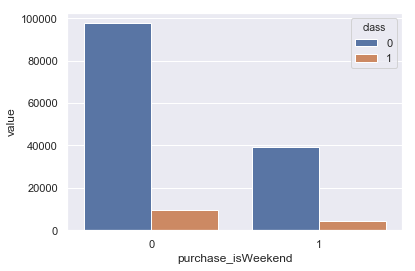

In [62]:
ct = pd.crosstab(merged_fraud_df_selected['purchase_isWeekend'],merged_fraud_df_selected['class'])
# now stack and reset
stacked = ct.stack().reset_index().rename(columns={0:'value'})

# plot grouped bar chart
sns.barplot(x=stacked.purchase_isWeekend, y=stacked.value, hue=stacked['class'])

1 . Explain how different assumptions about the cost of false positives vs false negatives would impact the model. 

Precision is the ratio tp / (tp + fp). Recall is the ratio tp / (tp + fn). This model has recall 0.91 and precision 0.89. So the false negative cost is less than false positive. It means that the model can recognize almost all positive cases.


2 . Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics? 

So from the above figures, we can see that, fraudulent activities usually come from users with these characteristics: using Chrome, male, in mature adult, from Americas, and purchase at the Weekend



3 . Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

So I would build the system that focus on the characteristic of users with most fraudulent activities. In this way, the system could help my business reduce cost of fraudulent activities. 


In [63]:
logreg.feature_importances_

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'